# Quantum pathfinder: the vehicle routing optimal solver

Quantum pathfinder is a optimization tool designed to find the optimal set of routes for a number of vehicles to traverse in order to deliver to a given set of customers. Quantum Pathfinder uses a quadratic unconstrained binary optimization (**QUBO**) representation of the well-known problem of the Vehicle Routing Problem [VRP](https://en.wikipedia.org/wiki/Vehicle_routing_problem) and solves it using the Quantum Approximation Optimization Algorithm **(QAOA)**. We compare the results using QAOA and CPLEX a classical solver. 


<center><img src="Images/Cost-fun.png" width="800"></center>
<center><img src="Images/Example.png" width="800"></center>



In [1]:
import numpy as np

## 1. Problem Formulation

For the problem formulation we used the qiskit optimization package. It includes the formulation of the VRP problem.


In [2]:
from qiskit_optimization.applications.vehicle_routing import VehicleRouting
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
import random
import networkx as nx
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer
import matplotlib.pyplot as plt
backend = Aer.get_backend("qasm_simulator")


Number of variables: 12
The optimal solution based on CPLEX


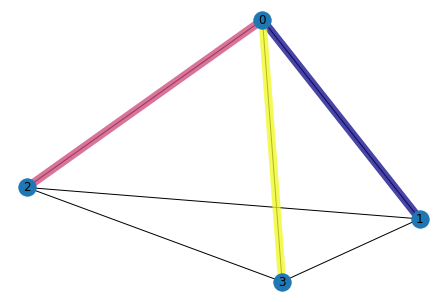

In [7]:
n = 4
low = 0
high = 50
pos = {i: (random.randint(low, high), random.randint(low, high)) for i in range(n)}
G = nx.random_geometric_graph(n, np.hypot(high - low, high - low) + 1, pos=pos)
for w, v in G.edges:
    delta = [
        G.nodes[w]["pos"][i] - G.nodes[v]["pos"][i] for i in range(2)
    ]
    G.edges[w, v]["weight"] = np.rint(np.hypot(delta[0], delta[1]))
problem = VehicleRouting(G, 3)
qp = problem.to_quadratic_program()
print(f"Number of variables: {len(qp.variables)}")
result = CplexOptimizer().solve(qp) 
print("The optimal solution based on CPLEX")
problem.draw(result, pos)

## 2. Problem Solution using Qiskit

Qiskit has implemented the function QAOA that can be used to solve the vehicle routing efficiently

In [8]:
intermediate_info = {'nfev': [],'parameters': [],'stddev': [], 'mean': []}
    
def callback(nfev, parameters, mean, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['mean'].append(mean)
    intermediate_info['stddev'].append(stddev)

qaoa_qiskit = MinimumEigenOptimizer(QAOA(optimizer= COBYLA(maxiter=100), reps=1, quantum_instance=backend, callback=callback))
sol_qaoa_qiskit = qaoa_qiskit.solve(qp)


In [9]:
sol_qaoa_qiskit

optimal function value: 132.0
optimal value: [1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
status: SUCCESS

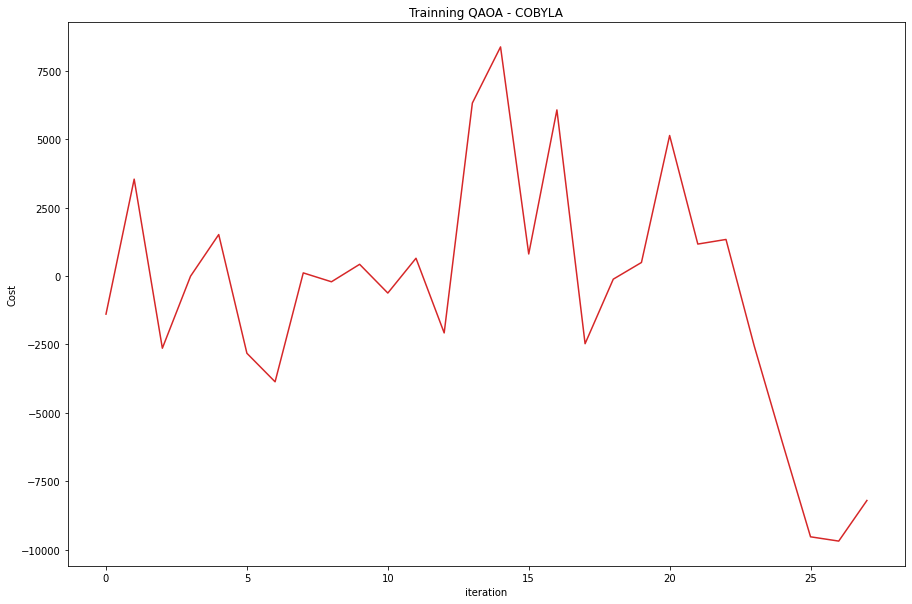

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(intermediate_info["mean"], label="COBYLA", color="tab:red")
ax.set_title("Trainning QAOA - COBYLA")
ax.set_xlabel("iteration")
ax.set_ylabel("Cost")
fig.savefig("./Images/COBYLA-training.png")

The optimal solution based on QAOA


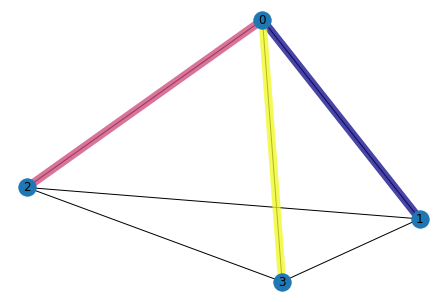

In [13]:
print("The optimal solution based on QAOA")
problem.draw(sol_qaoa_qiskit, pos)

## 3. Solution using Pennylane and BraKet

There is not properly function to manage the QAOA for solving a combinatorial problem using pennylane. Therefore, we implement our own model to this end. Our function that can be find in the file **qaoa_penylane.py** is implemented to use a QuadraticProgram from a CPLEX file and produce the cost function associated with the QUBO problem. We use as backend the AWS braket local and the default simulator from pennylane.

In [14]:
from qaoa_pennylane import qaoa_convert
from scipy.optimize import minimize
import pennylane as qml

#### Pennylane backend

In [15]:
nn = len(qp.variables)
params = [0.3,  0.5]
cost = lambda params : qaoa_convert(qp, params, p=1, shots=1024, backend_name="simulation").cost()
sol = minimize(cost, params, method="COBYLA")

#### AWS local simulator

In [16]:
nn = len(qp.variables)
params = [0.3,  0.5]
cost = lambda params : qaoa_convert(qp, params, p=1, shots=1024, backend_name="simulation").cost()
sol = minimize(cost, params, method="COBYLA")
probs = qaoa_convert(qp, sol.x, p=1, shots=1024, backend_name="simulation").probs()

In [19]:
probs

{'000000000000': 0.0146484375,
 '100000000000': 0.00390625,
 '010000000000': 0.0439453125,
 '110000000000': 0.0068359375,
 '011000000000': 0.001953125,
 '111000000000': 0.0009765625,
 '000100000000': 0.0009765625,
 '010100000000': 0.0048828125,
 '110100000000': 0.0009765625,
 '001100000000': 0.0009765625,
 '011100000000': 0.0009765625,
 '111100000000': 0.0009765625,
 '000010000000': 0.001953125,
 '010010000000': 0.00390625,
 '110010000000': 0.0009765625,
 '010110000000': 0.001953125,
 '000001000000': 0.001953125,
 '010001000000': 0.00390625,
 '110001000000': 0.0009765625,
 '111001000000': 0.0009765625,
 '000101000000': 0.0009765625,
 '000000100000': 0.048828125,
 '100000100000': 0.009765625,
 '010000100000': 0.1669921875,
 '110000100000': 0.037109375,
 '001000100000': 0.0009765625,
 '101000100000': 0.0009765625,
 '011000100000': 0.00390625,
 '111000100000': 0.001953125,
 '000100100000': 0.009765625,
 '100100100000': 0.0009765625,
 '010100100000': 0.0341796875,
 '110100100000': 0.009765

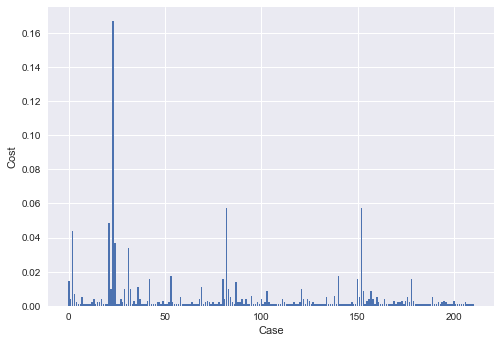

In [27]:
plt.figure()
plt.xlabel("Case")
plt.ylabel("Cost")
plt.style.use("seaborn")
plt.bar(range(len(probs.keys())), probs.values())
plt.savefig("./Images/histo.png")

# Conclusions


- The QAOA algorithm gives the same solution as CPLEX for the problem proposed which means that the QAOA is getting the optimal solution for this problem.
- The Pennylane solution needs an improvement to classify the correct solution. However, we create a function that combines a model from CPLEX QuadraticProgram and pennylane. This tool will be helpful for a easier user interface to encode QUBO problems.
- Future work involves using real devices with error mitigation